Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [300]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [301]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b

# Use following on Colab
#data_dir_train = pathlib.Path("/content/gdrive/My Drive/Upgrad/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train")
#data_dir_test = pathlib.Path('/content/gdrive/My Drive/Upgrad/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Test')0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [302]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train")
data_dir_test = pathlib.Path('/Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Test')


In [303]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [304]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [305]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,            # Path to dataset directory
    validation_split=0.2,    # Reserve 20% of data for validation
    subset="training",       # This is the training subset
    seed=123,                # Seed for reproducibility
    image_size=(img_height, img_width),   # Resize all images to 224x224
    batch_size=batch_size            # Number of images per batch
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [306]:
train_ds 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [307]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,
    subset="validation",     # This is the validation subset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [308]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [309]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [310]:
len_class_names = len(class_names)
len_class_names

9

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

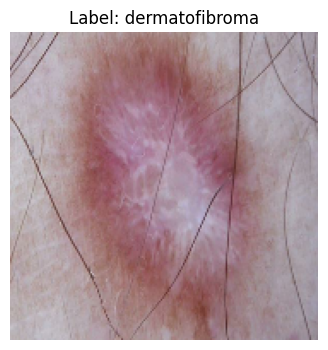

In [311]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
for images, labels in train_ds.take(1):  # Take the first batch
    # Select the first image and label from the batch
    image = images[0].numpy().astype("uint8")  # Convert to uint8 for visualization
    label = labels[0].numpy()  # Get the label index

    # Get the class names
    class_names = train_ds.class_names

    # Visualize
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")
    plt.show()
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [312]:
from tensorflow.keras.layers import Rescaling

In [313]:
### Your code goes here
rescaling_layer = Rescaling(1./255)

# Apply the Rescaling layer to the dataset
train_ds = train_ds.map(lambda x, y: (rescaling_layer(x), y))
val_ds = val_ds.map(lambda x, y: (rescaling_layer(x), y))

# Verify the normalized values
for images, labels in train_ds.take(1):
    print("Normalized image values:", images[0][0][0].numpy())  # Print a single pixel value

# Verify the normalized values
for images, labels in val_ds.take(1):
    print("Normalized image values:", images[0][0][0].numpy())  # Print a single pixel value


Normalized image values: [0.5476689  0.5437473  0.52806103]
Normalized image values: [0.8810598  0.87713826 0.8967461 ]


In [314]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [315]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [316]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [317]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),  # First convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Flatten the feature maps to feed into the dense layer
    layers.Dense(128, activation='relu'),  # Fully connected dense layer
    layers.Dense(len_class_names, activation='softmax')  # Output layer with softmax
])

In [318]:
### Todo, choose an appropirate optimiser and loss function
#model.compile(optimizer='sgd',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [319]:
# View the summary of all layers
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [320]:
epochs = 20
history = model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_ds)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 316ms/step - accuracy: 0.2162 - loss: 2.2225 - val_accuracy: 0.3913 - val_loss: 2.5015
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.4263 - loss: 1.5197 - val_accuracy: 0.2609 - val_loss: 2.6408
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 353ms/step - accuracy: 0.5122 - loss: 1.3011 - val_accuracy: 0.2609 - val_loss: 3.4149
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 476ms/step - accuracy: 0.5884 - loss: 1.1393 - val_accuracy: 0.2609 - val_loss: 2.9689
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 89s 526ms/step - accuracy: 0.6706 - loss: 0.9066 - val_accuracy: 0.1739 - val_loss: 3.2495
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 472ms/step - accuracy: 0.7245 - loss: 0.7695 - val_accuracy: 0.2174 - val_loss: 3.7147
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 466ms/step - accuracy: 0.7803 - loss: 0.6049 - val_accuracy: 0.1739 - val_loss: 3.4634
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 453ms/step - accuracy: 0.8288 - loss: 0

### Visualizing training results

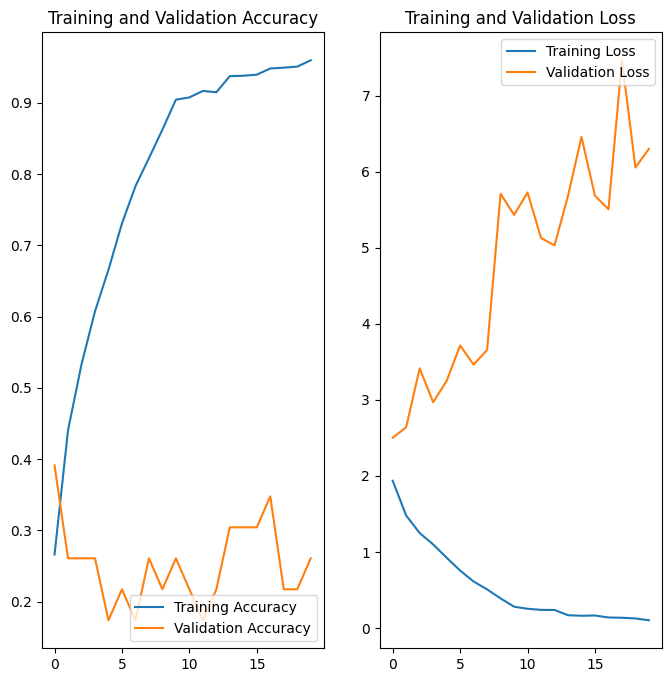

In [321]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### It is an overfit because Loss is decreasing, but val_loss is increasing

### Introduce Augmentation through RandomFlip, RandomRotation, RandomZoom & RandomContrast

In [334]:
from tensorflow.keras import layers, models
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),  # First convolutional layer
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),  # Flatten the feature maps to feed into the dense layer
    layers.Dense(128, activation='relu'),  # Fully connected dense layer
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len_class_names, activation='softmax')  # Output layer with softmax
])



### Compiling the model2

In [335]:
## Your code goes here

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### View the summary of all layers of model2

In [336]:
model2.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_88 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 178, 178, 32)   │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_5               │ (None, 178, 178, 32)   │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,649,545 (25.37 MB)

 Trainable params: 6,648,841 (25.36 MB)

 Non-trainable params: 704 (2.75 KB)

### Training the model2

In [337]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history1 = model2.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_ds)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3073 - loss: 2.3902 - val_accuracy: 0.0000e+00 - val_loss: 2.7570
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.3978 - loss: 1.7653 - val_accuracy: 0.2609 - val_loss: 2.0764
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.4373 - loss: 1.5589 - val_accuracy: 0.0435 - val_loss: 3.2211
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.4497 - loss: 1.4998 - val_accuracy: 0.0435 - val_loss: 13.5050
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.4720 - loss: 1.3942 - val_accuracy: 0.1304 - val_loss: 12.1953
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.4826 - loss: 1.3681 - val_accuracy: 0.1739 - val_loss: 14.5561
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.5102 - loss: 1.3370 - val_accuracy: 0.0435 - val_loss: 41.8361
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.5140 - loss: 1.2829 - 

### Visualizing the results

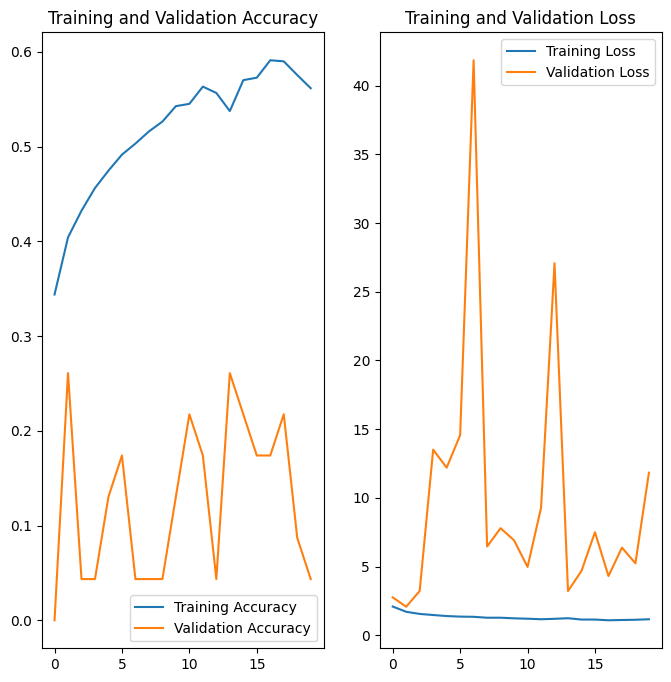

In [338]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [339]:
## Your code goes here.
from collections import Counter

# Count samples in each class
class_counts = Counter()
for _, labels in train_ds:
    class_counts.update(labels.numpy())


# Map class names to their counts
class_distribution = {class_names[i]: count for i, count in class_counts.items()}

# Print class distribution
print("Class Distribution:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")

Class Distribution:
basal cell carcinoma: 721
actinic keratosis: 493
nevus: 677
seborrheic keratosis: 456
dermatofibroma: 455
melanoma: 755
pigmented benign keratosis: 773
squamous cell carcinoma: 569
vascular lesion: 493


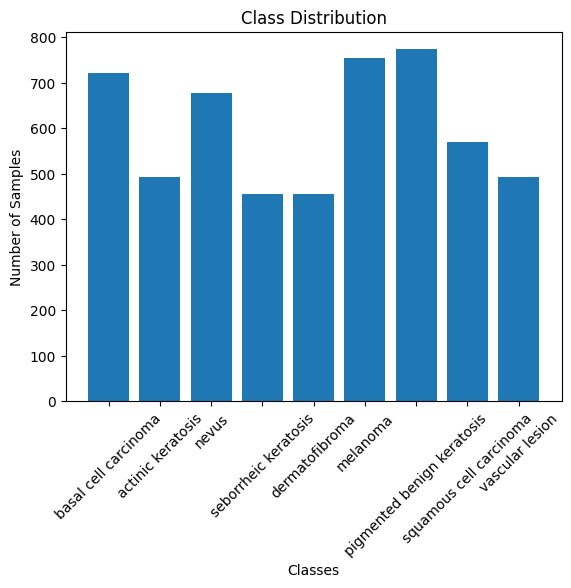

In [340]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [341]:
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 1.70


#### **Todo:** Write your findings here: 
#### Q) Which class has the least number of samples? 
#### Answer: dermatofibroma
#### Q) Which classes dominate the data in terms proportionate number of samples?
#### Answer: pigmented benign keratosis & dermatofibroma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [240]:
!/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [277]:
path_to_training_dataset='/Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/'
import Augmentor
for i in class_names:
    #print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30A0E37A0>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 296.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3178AE360>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 301.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x353E5B890>: 100%|██████████████████████████████████████████████████████| 500/500 [00:01<00:00, 319.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x317A24200>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.94 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x35324E690>: 100%|█████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3532D4A10>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 308.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3131DED20>: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 144.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3178AF920>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 301.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x317875B20>: 100%|██████████████████████████████████████████████████████| 500/500 [00:01<00:00, 307.43 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [278]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [344]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
dataframe_dict_new

In [346]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [347]:
df2.head()

,Path,Label
0,/Users/ashish/Documents/Ashish/Upgrad/Course-7...,melanoma
1,/Users/ashish/Documents/Ashish/Upgrad/Course-7...,melanoma
2,/Users/ashish/Documents/Ashish/Upgrad/Course-7...,melanoma
3,/Users/ashish/Documents/Ashish/Upgrad/Course-7...,melanoma
4,/Users/ashish/Documents/Ashish/Upgrad/Course-7...,melanoma


In [348]:
#new_df = original_df.append(df2)

In [349]:
#print(dataframe_dict_new)

In [350]:
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [359]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [360]:
data_dir_train="/Users/ashish/Documents/Ashish/Upgrad/Course-7-ML-3/Module-4-Melanoma-Detection-Assignment/Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [361]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model3 with normalization and rebalanced images

In [362]:
model3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),  # First convolutional layer
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),  # Flatten the feature maps to feed into the dense layer
    layers.Dense(128, activation='relu'),  # Fully connected dense layer
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len_class_names, activation='softmax')  # Output layer with softmax
])

### View the summary of all layers for model3

In [363]:
model3.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_8 (RandomFlip)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_8               │ (None, 178, 178, 32)   │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_8 (RandomZoom)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_8               │ (None, 178, 178, 32)   │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,649,545 (25.37 MB)

 Trainable params: 6,648,841 (25.36 MB)

 Non-trainable params: 704 (2.75 KB)

### Compile your model3 

In [364]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train your model3

In [365]:
epochs = 50
history3 = model3.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_ds)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.3024 - loss: 2.3067 - val_accuracy: 0.3341 - val_loss: 2.1005
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.4046 - loss: 1.7020 - val_accuracy: 0.2984 - val_loss: 2.2129
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.4343 - loss: 1.5778 - val_accuracy: 0.1745 - val_loss: 4.2676
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.4686 - loss: 1.4676 - val_accuracy: 0.2376 - val_loss: 2.5957
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.4724 - loss: 1.4263 - val_accuracy: 0.1589 - val_loss: 8.7048
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.4763 - loss: 1.3953 - val_accuracy: 0.1574 - val_loss: 6.2309
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.4992 - loss: 1.3455 - val_accuracy: 0.4878 - val_loss: 1.4044
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.5238 - loss: 1.2914 - val_accu

#### **Todo:**  Visualize the model results

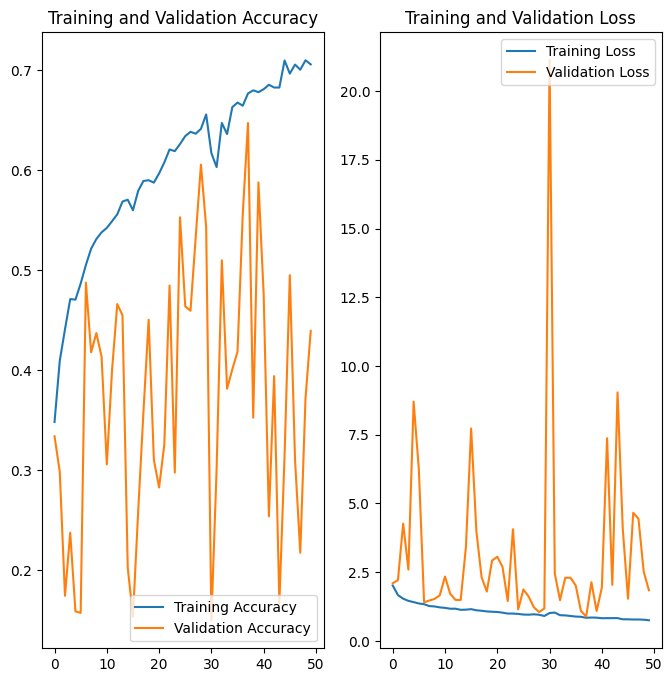

In [369]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Class rebalance helped and overfitting has gone.

## END ##